In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb

In [2]:
engine =create_engine('sqlite:///./Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-07-27,76.37,4.2,Papua New Guinea,-5.297074,148.894953,63.765909,67.072000,79.460000,4.550000,4.573333,4.500000,1
1,2020-07-28,88.76,4.3,Papua New Guinea,-5.297074,148.894953,61.451364,67.670000,78.664286,4.540909,4.393333,4.485714,1
2,2020-07-29,83.01,4.4,Papua New Guinea,-5.297074,148.894953,64.770000,66.487333,86.885714,4.545455,4.366667,4.485714,1
3,2020-07-30,10.00,4.9,Papua New Guinea,-5.297074,148.894953,64.770000,64.040000,85.245714,4.545455,4.426667,4.571429,1
4,2020-07-31,195.88,4.3,Papua New Guinea,-5.297074,148.894953,73.219091,75.197333,102.524286,4.531818,4.426667,4.500000,1


In [4]:

engine =create_engine('sqlite:///./Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-08-03,140.81,4.4,Papua New Guinea,-5.297074,148.894953,73.251364,70.354000,83.355714,4.718182,4.820000,4.942857,NaN
1,2020-08-04,172.48,5.4,Papua New Guinea,-5.297074,148.894953,76.803636,75.935333,106.567143,4.763636,4.893333,4.857143,NaN
2,2020-08-05,94.65,5.0,Papua New Guinea,-5.297074,148.894953,79.948636,76.711333,105.600000,4.790909,4.933333,4.971429,NaN
3,2020-08-06,196.24,4.8,Papua New Guinea,-5.297074,148.894953,87.892273,89.127333,113.395714,4.813636,4.926667,5.071429,NaN
4,2020-08-06,85.48,4.7,Papua New Guinea,-5.297074,148.894953,88.371818,81.767333,124.178571,4.809091,4.953333,4.914286,NaN


In [6]:

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [ ]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

In [ ]:
# random forest classifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

In [ ]:
pred=CV_rfc.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score

print(roc_auc_score(y_test, pred))
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
print('MAE: ', mean_absolute_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print('Accuracy: %.3f' % accuracy_score(y_test, pred))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

dtest: <xgboost.core.DMatrix object at 0x7f2c36e86650>
preds: [2.1928204e-04 6.4171159e-05 2.2729853e-04 ... 1.5437545e-03 4.2952137e-04
 1.3642567e-03]
0.9819322038836364
AUC: 0.9819
MAE:  0.022736849292761513
MSE:  0.013363177736702446
RMSE:  0.006681588868351223


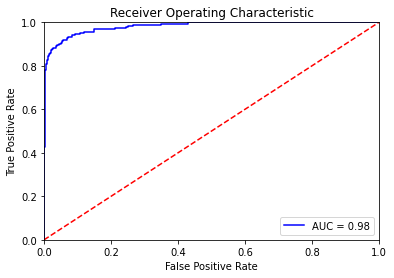

Confusion Matrix: 
 [[3590   23]
 [  37  153]]
Accuracy: 0.984

Recall 'TP/TP+FN' =  0.8052631578947368


In [ ]:
# XGboost
# from sklearn.metrics import roc_curve, auc, accuracy_score
# from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
print("dtest:", dtest)
print("preds:", preds)
print (roc_auc_score(y_test, preds))

fpr_xg, tpr_xg, _ = roc_curve(y_test, preds)
roc_auc_xg = auc(fpr_xg, tpr_xg)
print('AUC:', np.round(roc_auc_xg,4))
print('MAE: ', mean_absolute_error(y_test, preds))
mse_xg = mean_squared_error(y_test, preds)
print("MSE: ", mse_xg)
print("RMSE: ", mse_xg*(1/2.0)) 

ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xg, tpr_xg, 'b', label = 'AUC = %0.2f' % roc_auc_xg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

CM =confusion_matrix(y_test,ypred_bst)
print("Confusion Matrix: \n",CM)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
print('Accuracy: %.3f' % accuracy_score)
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

In [ ]:
!pip3 install catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
5000:	learn: 0.0142556	total: 1m 29s	remaining: 1m 29s
5001:	learn: 0.0142555	total: 1m 29s	remaining: 1m 29s
5002:	learn: 0.0142555	total: 1m 29s	remaining: 1m 29s
5003:	learn: 0.0142555	total: 1m 29s	remaining: 1m 29s
5004:	learn: 0.0142555	total: 1m 30s	remaining: 1m 29s
5005:	learn: 0.0142555	total: 1m 30s	remaining: 1m 29s
5006:	learn: 0.0142555	total: 1m 30s	remaining: 1m 29s
5007:	learn: 0.0142551	total: 1m 30s	remaining: 1m 29s
5008:	learn: 0.0142551	total: 1m 30s	remaining: 1m 29s
5009:	learn: 0.0142551	total: 1m 30s	remaining: 1m 29s
5010:	learn: 0.0142551	total: 1m 30s	remaining: 1m 29s
5011:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5012:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5013:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5014:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5015:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5016:	learn: 0.0142550	total: 1m 30s	remaining: 1m 29s
5017:	learn: 0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

0.942874415487931
AUC: 0.9429


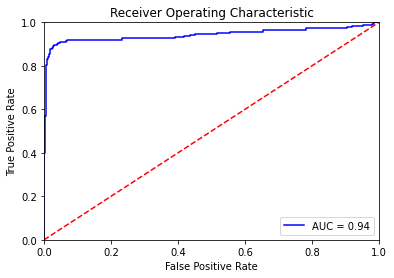

MAE:  0.016828819353142257
MSE:  0.016828819353142257
RMSE:  0.008414409676571128
Confusion Matrix: 
 [[3586   27]
 [  37  153]]
Accuracy: 0.983

Recall 'TP/TP+FN' =  0.8052631578947368


In [ ]:
# catboost model
from catboost import Pool,CatBoostRegressor   
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

train_pool = Pool(X_train, y_train)
# train_dataset = Pool(X_train, y_train) 
# test_dataset = Pool(X_test, y_test)
model_CBR = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
model_CBR.fit(
    X_train, y_train,
    plot =True
) 
cb_prediction = model_CBR.predict(X_test)
cbr_pred = np.array(cb_prediction)
cbr_pred  = cbr_pred > 0.5
cbr_pred = cbr_pred.astype(int)  

#implementing GridSearchCV using Support Vector Regression 
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train, y_train)
print (roc_auc_score(y_test, cb_prediction))
fpr_cat, tpr_cat, _ = roc_curve(y_test, cb_prediction)
roc_auc_catboost = auc(fpr_cat, tpr_cat)
print('AUC:', np.round(roc_auc_catboost,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cat, tpr_cat, 'b', label = 'AUC = %0.2f' % roc_auc_catboost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('MAE: ', mean_absolute_error(y_test, cbr_pred))
mse_cat = mean_squared_error(y_test, cbr_pred)
print("MSE: ", mse_cat)
print("RMSE: ", mse_cat*(1/2.0)) 

Cm =confusion_matrix(y_test,cbr_pred)
print("Confusion Matrix: \n",Cm)
Tn = Cm[0][0]
Fn = Cm[1][0]
Tp = Cm[1][1]
Fp = Cm[0][1]
accuracy_catboost = (Tp + Tn)/ (Tp + Fn + Tn + Fp)
print('Accuracy: %.3f' % accuracy_catboost)
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,cbr_pred))
